In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
import edrixs
from matplotlib import ticker, patches
# All the RIXS data are multiplied by 10 to avoid using small numbers for the colorscale.

In [2]:
%matplotlib inline
plt.rcParams['font.size'] = 7

In [3]:
def order_param(x, TN=130., I0=1., beta=0.1):
    y = np.zeros(len(x), dtype=float)
    choose = x<=TN
    y[choose] = I0 * (1 - x.astype(float)[choose] / TN) ** (2 * beta)
    return y

def load_var(filename, form='pickle'):
    """
    Load the variable.
    Example
    -------
    >>> data = load_var('data.pkl')
    """
    if form=='numpy':
        data = np.load(filename)
    elif form=='pickle':
        with open(filename, 'rb') as file:
            data = pickle.load(file)
        file.close
    return data

def make_theme(ax, ticklength=6):
    """ Apply the theme for figures """
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.tick_params(which='major', direction='in', left=True, bottom=True, top=True, right=True, width=0.5, length=ticklength)
    ax.tick_params(which='minor', direction='in', left=True, bottom=True, top=True, right=True, width=0.5, length=ticklength/2)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)

def enlarge(x0):
    """ Extend the axis: enlarge(vector) """
    if isinstance(x0, list):
        x = np.array(x0)
    else:
        x = x0-0
    new_x = np.zeros(np.size(x)+1)
    new_x[1:-1] = (x[1:]+x[:-1])/2
    new_x[0] = 3./2.*x[0]-1./2.*x[1]
    new_x[-1] = 3./2.*x[-1]-1./2.*x[-2]
    return new_x

def plot_image(image, x=None, y=None, ax=None, imshow=False, pmin=1, pmax=99, vmin=None, vmax=None, aspect='auto', cbar=False, cart_label=None, cmap='viridis'):
    """ Plot 2D Image """
    if ax is None:
        fig, ax = plt.subplots()
    if vmin == None:
        vmin = np.nanpercentile(image, pmin)
    if vmax == None:
        vmax = np.nanpercentile(image, pmax)
    if x is None or y is None:
        imshow = True
    if imshow:
        if x is None and y is None:
            art = ax.imshow(image, vmin=vmin, vmax=vmax, interpolation=None, aspect=aspect, origin=None, cmap=cmap, rasterized=True)
        elif x is None:
            art = ax.imshow(image, vmin=vmin, vmax=vmax, interpolation=None, aspect=aspect, origin='lower', cmap=cmap, rasterized=True,
                            extent=[0, np.array(image).shape[1]-1, np.min(y), np.max(y)])
        elif y is None:
            art = ax.imshow(image, vmin=vmin, vmax=vmax, interpolation=None, aspect=aspect, origin='lower', cmap=cmap, rasterized=True,
                            extent=[np.min(x), np.max(x), 0, np.array(image).shape[0]-1])
        else:
            art = ax.imshow(image, vmin=vmin, vmax=vmax, interpolation=None, aspect=aspect, origin='lower', cmap=cmap, rasterized=True,
                            extent=[np.min(x), np.max(x), np.min(y), np.max(y)])
    else:
        if x is None:
            x = np.arange(np.array(image).shape[1])
        if y is None:
            y = np.arange(np.array(image).shape[0])
        art = ax.pcolormesh(enlarge(x), enlarge(y), image, vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
        ax.axis(aspect)
    if cbar:
        cart = plt.colorbar(art, ax=ax)
        if cart_label is not None: cart.set_label(cart_label)
        return ax, art, cart
    else:
        return ax, art

def turbo_w():
    """
    modified turbo colormap with white background
    cmap = turbo_w()
    """
    cmap = np.load('misc/white_turbo.npy')
    return mcolors.ListedColormap(cmap)

def get_color(color):
    fcolor = [color[0]*0.5+0.5, color[1]*0.5+0.5, color[2]*0.5+0.5, 1]
    ecolor = [color[0]*0.9, color[1]*0.9, color[2]*0.9, 1]
    lcolor = [color[0]*0.8, color[1]*0.8, color[2]*0.8, 1]
    return ecolor, fcolor, lcolor

def plot_label(ax, count, x=0, y=1.03, color='k'):
    ax.text(x, y, count, fontdict=dict(fontsize=9), transform=ax.transAxes, color=color)

# Figure 1

In [4]:
La438_THdep = load_var('RIXS_data/La438_THdep.pkl')

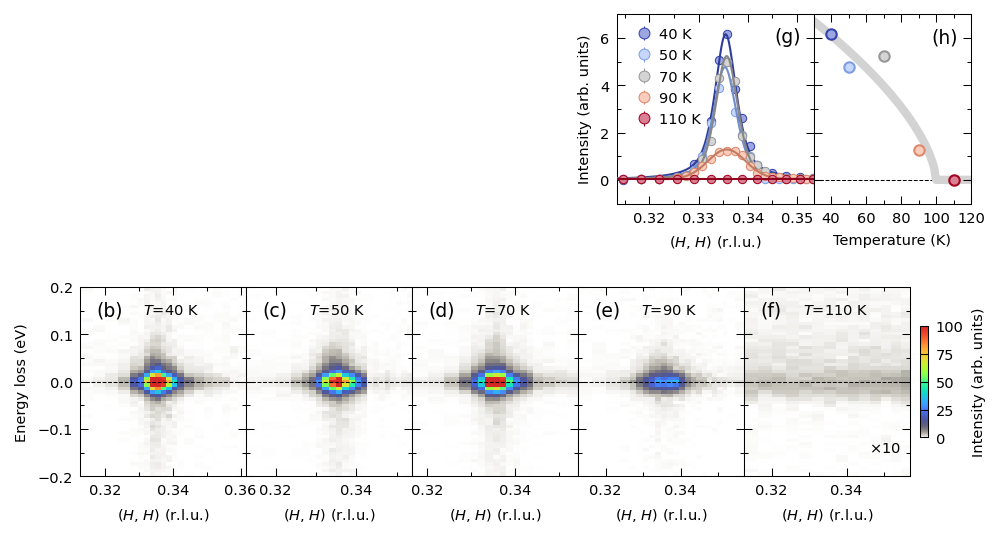

In [5]:
fig = plt.figure(figsize=(6.75,6.75/2*1.1), dpi=150)
gs1 = fig.add_gridspec(nrows=1, ncols=2, left=0.61, right=0.96, top=0.93, bottom=0.59, wspace=0, width_ratios=[1,0.8])
gs2 = fig.add_gridspec(nrows=1, ncols=5, left=0.08, right=0.9, top=0.44, bottom=0.1, wspace=0)
axs = [fig.add_subplot(gs) for gs in gs1] + [fig.add_subplot(gs) for gs in gs2]
cax = fig.add_axes([0.91,0.17,0.008,0.2]) # axis for colorbar

colors = plt.cm.coolwarm(np.linspace(0,1,len(La438_THdep['T'])))
colors[2] = mcolors.to_rgba('darkgrey')

for T, intensity, ax, color in zip(La438_THdep['T'], La438_THdep['Tdep_eline'], axs[2:], colors):
    # 1D data
    x = La438_THdep[f'T{T}']['Hrlu']
    y = La438_THdep[f'T{T}']['THdep_eline']
    yerr = La438_THdep[f'T{T}']['THdep_eline_err']
    ecolor, fcolor, lcolor = get_color(color)
    axs[0].errorbar(x, y*10, yerr=yerr*10, fmt='o', ls='none', ms=4, mew=0.5, elinewidth=0.5, color=fcolor, ecolor=ecolor, mec=ecolor, label=f'{T} K', zorder=int(T))
    # fitting
    x = La438_THdep[f'T{T}']['THdep_fit_x']
    y = La438_THdep[f'T{T}']['THdep_fit_y']
    axs[0].plot(x, y*10, '-', lw=1, color=lcolor, zorder=int(T+1))
    axs[1].errorbar(T, intensity*10, fmt='o', ls='none', ms=5, lw=0.5, color=fcolor, ecolor=ecolor, mec=ecolor)
    # colorplot
    if T<100:
        _, art = plot_image(La438_THdep[f'T{T}']['THmap_I']*10, ax=ax, x=La438_THdep[f'T{T}']['Hrlu'], y=La438_THdep[f'T{T}']['THmap_eloss'], cmap=turbo_w(), vmin=0., vmax=100.)
    else:
        _, art = plot_image(La438_THdep[f'T{T}']['THmap_I']*100, ax=ax, x=La438_THdep[f'T{T}']['Hrlu'], y=La438_THdep[f'T{T}']['THmap_eloss'], cmap=turbo_w(), vmin=0., vmax=100.)
    ax.text(0.55, 0.88, f'$T$={T} K', transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
    
    # format: colorplots
    make_theme(ax, ticklength=4)
    ax.axhline(y=0, ls='--', lw=0.5, color='k')
    ax.set_xlabel(r'($H$, $H$) (r.l.u.)')
    ax.set_ylim(-0.2,0.2)
    ax.set_yticks(np.arange(-0.2,0.21,0.1))

color = mcolors.to_rgba('darkcyan')
ecolor, fcolor, lcolor = get_color(color)
x = np.arange(20,130,1)
y = order_param(x, TN=100., I0=8.37995783, beta=0.31029985	)
axs[1].plot(x, y, ls='-', ms=5, lw=4, color='lightgray', zorder=-1)
axs[-1].text(0.85, 0.15, r'$\times$10', transform=axs[-1].transAxes, horizontalalignment='center', verticalalignment='center')

# format: 1D plots
for ax in axs[:2]:
    make_theme(ax, ticklength=4)
axs[0].legend(loc='upper left', frameon=False, markerscale=1.3, handletextpad=0)
axs[0].set_xlim(1/3-0.02,1/3+0.02)
axs[0].set_xticks(np.arange(0.32,0.36,0.01))
axs[0].set_xlabel(r'($H$, $H$) (r.l.u.)')
axs[0].set_ylim(-1,7)
axs[0].set_yticks(np.arange(0,6.1,2))
axs[0].set_ylabel('Intensity (arb. units)')
axs[1].tick_params(labelleft=False)
axs[1].axhline(y=0, ls='--', lw=0.5, color='k', zorder=-2)
axs[1].set_xlim(30,120)
axs[1].set_xticks(np.arange(40,121,20))
axs[1].set_xlabel('Temperature (K)')
axs[1].set_ylim(-1,7)
axs[1].set_yticks(np.arange(0,6.1,2))

# format: colorplots
for ax in axs[3:]:
    ax.tick_params(labelleft=False)
axs[2].set_ylabel('Energy loss (eV)')

# colorbar
cbar = plt.colorbar(art, cax=cax)
cbar.set_ticks(np.arange(0,100.1,25))
cbar.ax.tick_params(width=0.5, direction='in', length=4, left=True, right=True)
cbar.outline.set_linewidth(0.5)
cbar.set_label('Intensity (arb. units)')

plot_label(axs[0], '(g)', x=0.8,  y=0.85, color='k')
plot_label(axs[1], '(h)', x=0.75, y=0.85, color='k')
plot_label(axs[2], '(b)', x=0.1,  y=0.85, color='k')
plot_label(axs[3], '(c)', x=0.1,  y=0.85, color='k')
plot_label(axs[4], '(d)', x=0.1,  y=0.85, color='k')
plot_label(axs[5], '(e)', x=0.1,  y=0.85, color='k')
plot_label(axs[6], '(f)', x=0.1,  y=0.85, color='k')

# Figure 2

In [6]:
La438_Emap = load_var('RIXS_data/La438_Emap.pkl')

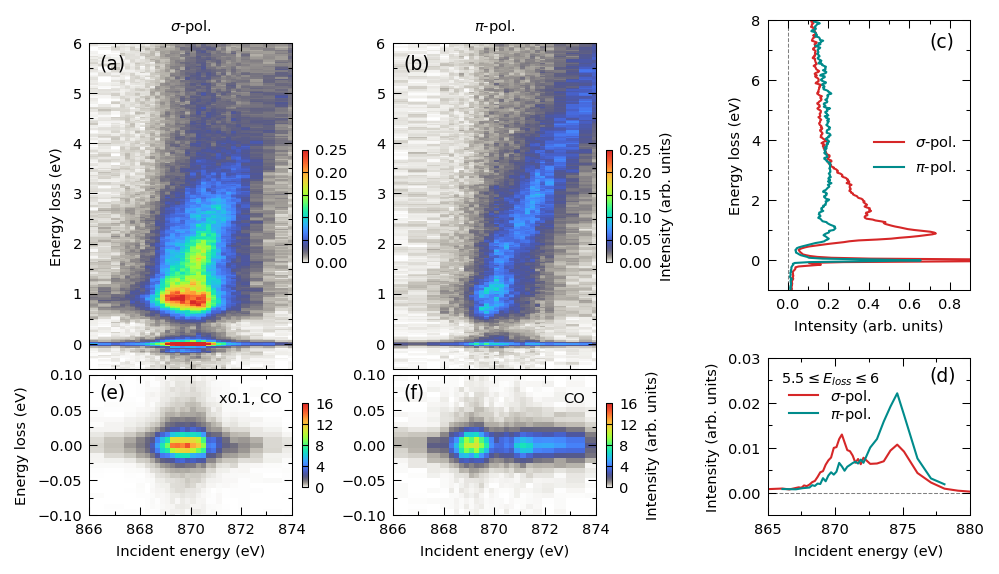

In [7]:
fig = plt.figure(figsize=(6.75,6.75/1.8), dpi=150)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.08, right=0.28, top=0.94, bottom=0.36)
gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.38, right=0.58, top=0.94, bottom=0.36)
gs3 = fig.add_gridspec(nrows=1, ncols=1, left=0.08, right=0.28, top=0.35, bottom=0.1)
gs4 = fig.add_gridspec(nrows=1, ncols=1, left=0.38, right=0.58, top=0.35, bottom=0.1)
gs5 = fig.add_gridspec(nrows=1, ncols=1, left=0.75, right=0.95, top=0.98, bottom=0.5)
gs6 = fig.add_gridspec(nrows=1, ncols=1, left=0.75, right=0.95, top=0.38, bottom=0.1)
axs = [fig.add_subplot(gs) for gs in gs1] + [fig.add_subplot(gs) for gs in gs2]
axs += [fig.add_subplot(gs) for gs in gs3] + [fig.add_subplot(gs) for gs in gs4]
axs += [fig.add_subplot(gs) for gs in gs5] + [fig.add_subplot(gs) for gs in gs6]

# Emaps & REXS
_, art = plot_image(La438_Emap['L2LV']['Emap_I']*10, La438_Emap['L2LV']['Ei'], La438_Emap['L2LV']['Emap_eloss'], ax=axs[0], cmap=turbo_w(), vmin=0., vmax=0.25)
cax = fig.add_axes([0.29,0.55,0.006,0.2])
cbar = plt.colorbar(art, cax=cax)
cbar.set_ticks(np.arange(0,0.26,0.05))
cbars = [cbar]
_, art = plot_image(La438_Emap['L2LV_HR']['Emap_I']*10*0.1, La438_Emap['L2LV_HR']['Ei'], La438_Emap['L2LV_HR']['Emap_eloss'], ax=axs[2], cmap=turbo_w(), vmin=0., vmax=16)
cax = fig.add_axes([0.29,0.15,0.006,0.15])
cbar = plt.colorbar(art, cax=cax)
cbar.set_ticks(np.arange(0,16.1,4))
cbars.append(cbar)
_, art = plot_image(La438_Emap['L2LH']['Emap_I']*10, La438_Emap['L2LH']['Ei'], La438_Emap['L2LH']['Emap_eloss'], ax=axs[1], cmap=turbo_w(), vmin=0., vmax=0.25)
cax = fig.add_axes([0.59,0.55,0.006,0.2])
cbar = plt.colorbar(art, cax=cax)
cbar.set_ticks(np.arange(0,0.26,0.05))
cbars.append(cbar)
_, art = plot_image(La438_Emap['L2LH_HR']['Emap_I']*10, La438_Emap['L2LH_HR']['Ei'], La438_Emap['L2LH_HR']['Emap_eloss'], ax=axs[3], cmap=turbo_w(), vmin=0., vmax=16)
cax = fig.add_axes([0.59,0.15,0.006,0.15])
cbar = plt.colorbar(art, cax=cax)
cbar.set_ticks(np.arange(0,16.1,4))
cbars.append(cbar)
# 1D cuts
axs[4].plot([np.trapz(Emap0*10, x=La438_Emap['L2LV']['Ei']) for Emap0 in La438_Emap['L2LV']['Emap_I']],
            La438_Emap['L2LV']['Emap_eloss'], '-', lw=1, color='C3', label=r'$\sigma$-pol.')
axs[4].plot([np.trapz(Emap0*10, x=La438_Emap['L2LH']['Ei']) for Emap0 in La438_Emap['L2LH']['Emap_I']],
            La438_Emap['L2LH']['Emap_eloss'], '-', lw=1, color='darkcyan', label=r'$\pi$-pol.')
choose = np.logical_and(La438_Emap['L2LV']['Emap_eloss']>=5.5, La438_Emap['L2LV']['Emap_eloss']<=6.)
axs[5].plot(La438_Emap['L2LV']['Ei'], np.trapz(La438_Emap['L2LV']['Emap_I'][choose]*10, x=La438_Emap['L2LV']['Emap_eloss'][choose], axis=0),
            '-', lw=1, color='C3', label=r'$\sigma$-pol.')
choose = np.logical_and(La438_Emap['L2LH']['Emap_eloss']>=5.5, La438_Emap['L2LH']['Emap_eloss']<=6.)
axs[5].plot(La438_Emap['L2LH']['Ei'], np.trapz(La438_Emap['L2LH']['Emap_I'][choose]*10, x=La438_Emap['L2LH']['Emap_eloss'][choose], axis=0),
           '-', lw=1, color='darkcyan', label=r'$\pi$-pol.')

# format: colorplots
for ax in axs[:4]:
    make_theme(ax, ticklength=4)
    ax.set_xlim(866, 874)
    ax.set_xticks(np.arange(866, 875, 2))
for ax in axs[:2]:
    ax.tick_params(labelbottom=False)
    ax.set_ylim(-0.5, 6)
    ax.set_yticks(np.arange(0,6.1,1))
for ax in axs[2:4]:
    ax.set_ylim(-0.1, 0.1)
    ax.set_yticks(np.arange(-0.1,0.11,0.05))
axs[2].text(0.95, 0.8, 'x0.1, CO', horizontalalignment='right', transform=axs[2].transAxes)
axs[3].text(0.95, 0.8, 'CO', horizontalalignment='right', transform=axs[3].transAxes)
axs[0].set_ylabel('Energy loss (eV)')
axs[2].set_ylabel('Energy loss (eV)')
axs[2].set_xlabel('Incident energy (eV)')
axs[3].set_xlabel('Incident energy (eV)')
# format: 1D cuts
make_theme(axs[4], ticklength=4)
axs[4].axvline(x=0, lw=0.5, ls='--', color='gray', zorder=-1)
axs[4].legend(loc='center right', frameon=False)
axs[4].set_xlim(-0.1,0.9)
axs[4].set_xticks(np.arange(0,0.9,0.2))
axs[4].set_ylim(-1, 8)
axs[4].set_yticks(np.arange(0,8.1,2))
axs[4].set_xlabel('Intensity (arb. units)')
axs[4].set_ylabel('Energy loss (eV)')
make_theme(axs[5], ticklength=4)
axs[5].axhline(y=0, lw=0.5, ls='--', color='gray', zorder=-1)
axs[5].legend(loc='upper left', frameon=False, title=r'5.5$\leq E_{loss}\leq$6', labelspacing=0)
axs[5].set_xlabel('Incident energy (eV)')
axs[5].set_ylabel('Intensity (arb. units)')
axs[5].set_xlim(865,880)
axs[5].set_xticks(np.arange(865,880.1,5))
axs[5].set_ylim(-0.005, 0.03)
axs[5].set_yticks(np.arange(0,0.031,0.01))
# colorbars
for cbar in cbars:
    cbar.ax.tick_params(width=0.5, direction='in', length=3, left=True, right=True)
    cbar.outline.set_linewidth(0.5)
cbars[2].set_label('Intensity (arb. units)')
cbars[3].set_label('Intensity (arb. units)')

axs[0].set_title(r'$\sigma$-pol.', fontsize=7)
axs[1].set_title(r'$\pi$-pol.', fontsize=7)

plot_label(axs[0], '(a)', x=0.05, y=0.92, color='k')
plot_label(axs[1], '(b)', x=0.05, y=0.92, color='k')
plot_label(axs[2], '(e)', x=0.05, y=0.83, color='k')
plot_label(axs[3], '(f)', x=0.05, y=0.83, color='k')
plot_label(axs[4], '(c)', x=0.8, y=0.9, color='k')
plot_label(axs[5], '(d)', x=0.8, y=0.85, color='k')

# Figure 3

In [8]:
ED_Emap = load_var('ED_calcs/RIXS_Emaps.pkl')

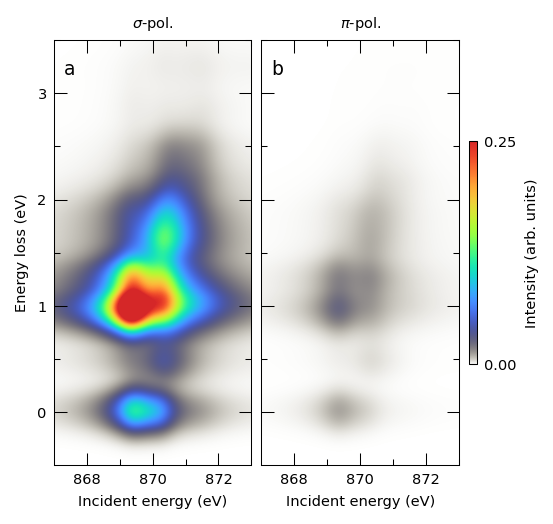

In [9]:
fig = plt.figure(figsize=(6.75/2,6.75/2), dpi=150)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.1, right=0.49, top=0.94, bottom=0.1)
gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.51, right=0.9, top=0.94, bottom=0.1)
axs = [fig.add_subplot(gs) for gs in gs1] + [fig.add_subplot(gs) for gs in gs2]

xoffset = 868.5

_, art = plot_image(ED_Emap['rixs_CO_lv'][:,:,0,:].sum(axis=0).T*5/8, x=ED_Emap['omega']+xoffset, y=ED_Emap['eloss'], ax=axs[0], vmin=0, vmax=0.25, cmap=turbo_w(), imshow=True)
_, art = plot_image(ED_Emap['rixs_CO_lh'][:,:,0,:].sum(axis=0).T*5/8, x=ED_Emap['omega']+xoffset, y=ED_Emap['eloss'], ax=axs[1], vmin=0, vmax=0.25, cmap=turbo_w(), imshow=True)
cax = fig.add_axes([0.92,0.3,0.015,0.44])
cbar = plt.colorbar(art, cax=cax)
cbar.set_ticks(np.arange(0,0.26,0.25))

for ax in axs:
    make_theme(ax)
    ax.set_xlim(-1.5+xoffset, 4.5+xoffset)
    ax.set_ylim(-0.5,3.5)
    ax.set_yticks(np.arange(0,3.1,1))
    ax.set_xlabel('Incident energy (eV)')
axs[0].set_ylabel('Energy loss (eV)')
axs[0].set_title(r'$\sigma$-pol.', fontsize=7)
axs[1].set_title(r'$\pi$-pol.', fontsize=7)
axs[1].tick_params(labelleft=False)
cbar.ax.tick_params(width=0.5, direction='in', length=3, left=True, right=True)
cbar.outline.set_linewidth(0.5)
cbar.set_label('Intensity (arb. units)')

plot_label(axs[0], 'a', x=0.05, y=0.92, color='k')
plot_label(axs[1], 'b', x=0.05, y=0.92, color='k')

# Figure 4

In [10]:
La438_XAS = load_var('RIXS_data/La438_XAS.pkl')
La438_Emap = load_var('RIXS_data/La438_Emap.pkl')
ED_REXS = load_var('ED_calcs/REXS_Delta_5p6.pkl')
ED_XAS = load_var('ED_calcs/xas_FmagSq_Delta_5p6.pkl')
wf = load_var('ED_calcs/wavefunctions_Delta_5p6.pkl')

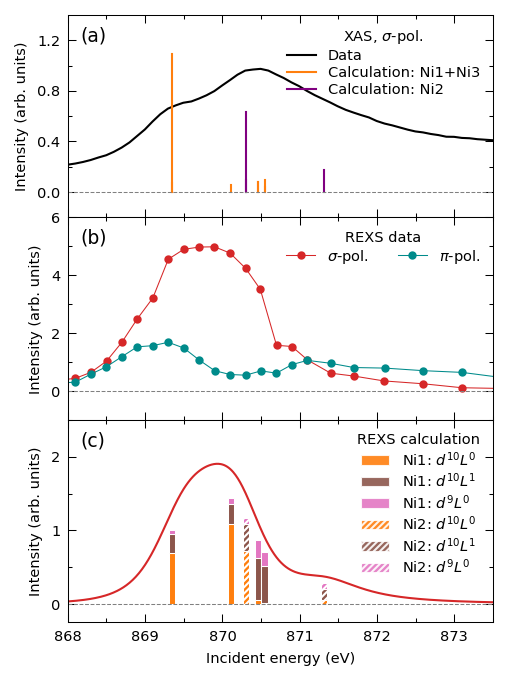

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(6.75/2,6.75/1.5), dpi=150, sharex=True, gridspec_kw=dict(hspace=0.,
                        top=0.98, bottom=0.08, left=0.12, right=0.96))

# data
axs[0].plot(La438_XAS[:,0], La438_XAS[:,1], '-', lw=1, color='k', label='Data')

axs[1].plot(La438_Emap['L2LV_HR']['Ei'], np.array(La438_Emap['L2LV_HR']['Eidep_eline'])*10, 'o-',
            color='C3', lw=0.5, ms=3, label='$\\sigma$-pol.', zorder=0)
axs[1].plot(La438_Emap['L2LH_HR']['Ei'], np.array(La438_Emap['L2LH_HR']['Eidep_eline'])*10, 'o-',
            color='darkcyan', lw=0.5, ms=3, label='$\\pi$-pol.', zorder=0)
axs[1].legend(loc='upper right', frameon=False, title='REXS data')

# calc
xoffset = 857
## XAS Ni1+Ni3
FmagSq = ED_XAS[0]
choose0 = np.logical_and(FmagSq[0]>=11, FmagSq[0]<=15)
choose1 = FmagSq[1][choose0]>=0.02*np.max(FmagSq[1][choose0])
for x, y in zip(FmagSq[0][choose0][choose1], FmagSq[1][choose0][choose1]):
    axs[0].plot([x+xoffset,x+xoffset], [0,y*5*2], '-', lw=1, color='C1')
## XAS Ni2
FmagSq = ED_XAS[1]
choose0 = np.logical_and(FmagSq[0]>=11, FmagSq[0]<=15)
choose1 = FmagSq[1][choose0]>=0.02*np.max(FmagSq[1][choose0])
for x, y in zip(FmagSq[0][choose0][choose1], FmagSq[1][choose0][choose1]):
    axs[0].plot([x+xoffset,x+xoffset], [0,y*5], '-', lw=1, color='purple')
## REXS
axs[2].plot(ED_REXS['omega']+xoffset, ED_REXS['rexs_CO_lv'], '-', lw=1, color='C3', zorder=0)
## wf
width = 0.08
for nn in range(len(wf['TM1']['omega'])):
    height = np.interp(wf['TM1']['omega'][nn]+xoffset, ED_REXS['omega']+xoffset, ED_REXS['rexs_CO_lv'])*0.8
    axs[2].bar(wf['TM1']['omega'][nn]+xoffset, height=wf['TM1']['d0L0'][nn]*height,
               color='C1', width=width, edgecolor='w', linewidth=0.5)
    axs[2].bar(wf['TM1']['omega'][nn]+xoffset, height=wf['TM1']['d0L1'][nn]*height,
               bottom=wf['TM1']['d0L0'][nn]*height,
               color='C5', width=width, edgecolor='w', linewidth=0.5)
    axs[2].bar(wf['TM1']['omega'][nn]+xoffset, height=wf['TM1']['d1L0'][nn]*height,
               bottom=(wf['TM1']['d0L0'][nn]+wf['TM1']['d0L1'][nn])*height,
               color='C6', width=width, edgecolor='w', linewidth=0.5)
for nn in range(len(wf['TM2']['omega'])):
    height = np.interp(wf['TM2']['omega'][nn]+xoffset, ED_REXS['omega']+xoffset, ED_REXS['rexs_CO_lv'])*0.8
    axs[2].bar(wf['TM2']['omega'][nn]+xoffset, height=wf['TM2']['d0L0'][nn]*height,
               color='C1', width=width, edgecolor='w', linewidth=0.5, hatch='////////')
    axs[2].bar(wf['TM2']['omega'][nn]+xoffset, height=wf['TM2']['d0L1'][nn]*height,
               bottom=wf['TM2']['d0L0'][nn]*height,
               color='C5', width=width, edgecolor='w', linewidth=0.5, hatch='////////')
    axs[2].bar(wf['TM2']['omega'][nn]+xoffset, height=wf['TM2']['d1L0'][nn]*height,
               bottom=(wf['TM2']['d0L1'][nn]+wf['TM2']['d0L0'][nn])*height,
               color='C6', width=width, edgecolor='w', linewidth=0.5, hatch='////////')

# legends
axs[0].plot(np.nan, np.nan, '-', lw=1, color='C1', label='Calculation: Ni1+Ni3')
axs[0].plot(np.nan, np.nan, '-', lw=1, color='purple', label='Calculation: Ni2')
axs[0].legend(title='XAS, $\\sigma$-pol.', loc='upper right', frameon=False, labelspacing=0.2)
axs[1].legend(loc='upper right', title='REXS data', frameon=False, labelspacing=0.2, ncol=2)
labels= [r'Ni1: $d^{10}L^0$',
         r'Ni1: $d^{10}L^1$',
         r'Ni1: $d^{9}L^0$',
         r'Ni2: $d^{10}L^0$',
         r'Ni2: $d^{10}L^1$',
         r'Ni2: $d^{9}L^0$']
artists = []
for color, hatch in zip(['C1', 'C5', 'C6']*2, [None]*3+['////////']*3):
    artists.append(patches.Patch(facecolor=color, hatch=hatch,  edgecolor='w', alpha=.9))
axs[2].legend(artists, labels, title='REXS calculation', loc='upper right', frameon=False, labelspacing=0.2)

# format
for ax in axs:
    make_theme(ax, ticklength=4)
axs[0].set_xlim(868,873.5)
axs[0].set_ylim(-0.2,1.4)
axs[0].set_yticks(np.arange(0,1.3,0.4))
axs[0].set_ylabel('Intensity (arb. units)')
axs[0].axhline(y=0, ls='--', lw=0.5, color='gray')
plot_label(axs[0], '(a)', x=0.03, y=0.87, color='k')

axs[1].set_ylim(-1,6)
axs[1].set_yticks(np.arange(0,7,2))
axs[1].set_ylabel('Intensity (arb. units)')
axs[1].axhline(y=0, ls='--', lw=0.5, color='gray')
plot_label(axs[1], '(b)', x=0.03, y=0.87, color='k')

axs[2].set_ylim(-0.25,2.5)
axs[2].set_yticks(np.arange(0,2.1,1))
axs[2].set_ylabel('Intensity (arb. units)')
axs[2].set_xlabel('Incident energy (eV)')
axs[2].axhline(y=0, ls='--', lw=0.5, color='gray')
plot_label(axs[2], '(c)', x=0.03, y=0.87, color='k')

# Supplementary Figure 1

In [12]:
Pr438_THdep = load_var('RIXS_data/Pr438_THdep.pkl')

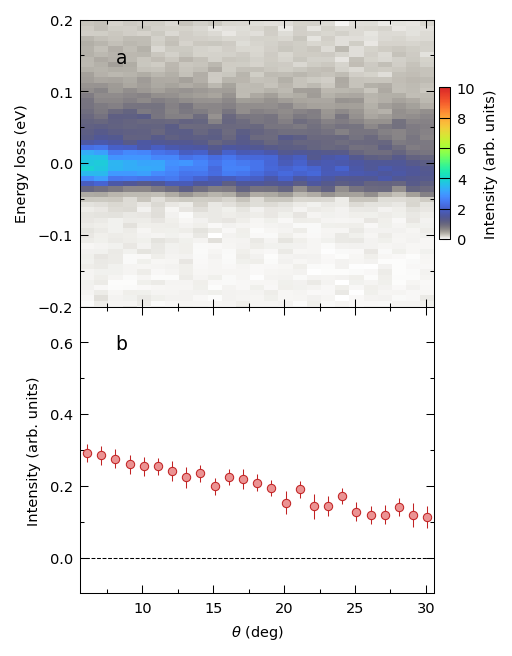

In [13]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6.75/2,6.75/1.5), dpi=150,
                        gridspec_kw=dict(hspace=0., top=0.95, bottom=0.1, left=0.15, right=0.85))

# data: 0.1 is the normalization factor for slit change
_, art = plot_image(Pr438_THdep['THmap_I']*0.1*10, ax=axs[0], x=Pr438_THdep['theta'], y=Pr438_THdep['THmap_eloss'],
                    cmap=turbo_w(), vmin=0., vmax=10.)
x = Pr438_THdep['theta']
y = Pr438_THdep['THdep_eline']
yerr = Pr438_THdep['THdep_eline_err']
ecolor, fcolor, lcolor = get_color(mcolors.to_rgba('C3'))
axs[1].errorbar(x, y*0.1*10, yerr=yerr*0.1*10, fmt='o', ls='none', ms=4, mew=0.5, elinewidth=0.5,
                color=fcolor, ecolor=ecolor, mec=ecolor)
# format
for ax in axs:
    make_theme(ax, ticklength=4)
axs[0].set_ylabel('Energy loss (eV)')
axs[0].set_ylim(-0.2,0.2)
axs[0].set_yticks(np.arange(-0.2,0.21,0.1))
axs[1].axhline(y=0, ls='--', lw=0.5, color='k')
axs[1].set_xticks(np.arange(10,31,5))
axs[1].set_xlabel(r'$\theta$ (deg)')
axs[1].set_ylim(-0.1,0.7)
axs[1].set_yticks(np.arange(0.,0.7,0.2))
axs[1].set_ylabel('Intensity (arb. units)')
# colorbar
cax = fig.add_axes([0.86,0.525+0.1,0.02,0.425-0.2])
cbar = plt.colorbar(art, cax=cax)
cbar.set_ticks(np.arange(0,11,2))
cbar.ax.tick_params(width=0.5, direction='in', length=4, left=True, right=True)
cbar.outline.set_linewidth(0.5)
cbar.set_label('Intensity (arb. units)')

plot_label(axs[0], 'a', x=0.1, y=0.85, color='k')
plot_label(axs[1], 'b', x=0.1, y=0.85, color='k')

# Supplementary Figure 3

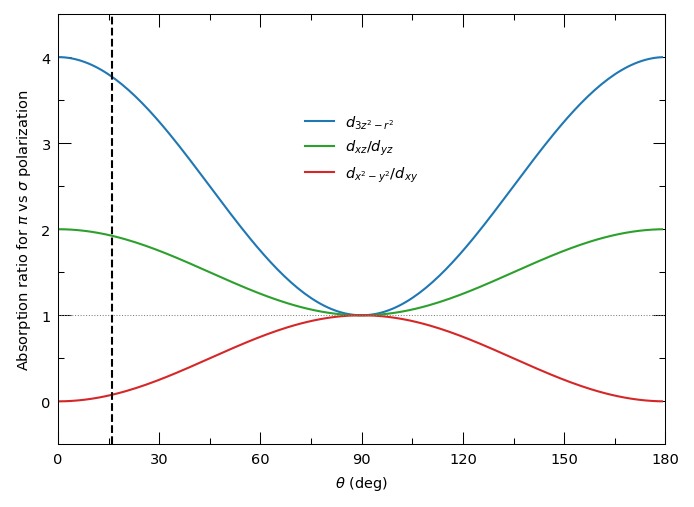

In [14]:
dd_levels = [0., 0., 1e3, 1e3, 1e3, 1e3, 2e3, 2e3, 3e3, 3e3]
emat_rhb = np.diag(dd_levels)
emat = edrixs.cb_op(emat_rhb, edrixs.tmat_r2c('d', ispin=True))
_, evecs = np.linalg.eigh(emat)
eigenvectors = dict(dz2=evecs[:,:2], dxzyz=evecs[:,2:6], dx2=evecs[:,6:8], dxy=evecs[:,8:])

D_Tmat = edrixs.get_trans_oper('dp12')

def get_I(thin, alpha, orbital):
    vector_i = eigenvectors[orbital]
    norb_v = vector_i.shape[1]
    Fij = np.zeros((3, norb_v, 2), dtype=complex) # (xyz, norb_v, norb_c)
    for i in range(3):
        for j in range(norb_v):
            Fij[i,j,:] = np.dot(np.conj(D_Tmat[i].T), vector_i[:,j])
    
    ei, ef = edrixs.dipole_polvec_rixs(thin*np.pi/180, 0., 0., alpha, 0.)
    intensity = np.vstack([np.abs(np.dot(ei, Fij[:,:,ncore]))**2 for ncore in range(2)])
    return intensity.sum(axis=(0,1))

fig, ax = plt.subplots(dpi=150, figsize=(6.75,6.75/2), gridspec_kw=dict(left=0.2, right=0.8, top=0.95, bottom=0.1))

orbitals = ['dz2', 'dxzyz', 'dx2']
orbital_labels = [r'$d_{3z^2-r^2}$', r'$d_{xz}/d_{yz}$', r'$d_{x^2-y^2}/d_{xy}$']
thins = np.arange(180)
arts = []

for orbital, label, color in zip(orbitals, orbital_labels, ['C0','C2','C3']):
    I1 = np.array([get_I(thin, 0., orbital) for thin in thins])
    I2 = np.array([get_I(thin, np.pi/2., orbital) for thin in thins])
    ax.plot(thins, I1/I2, label=label, color=color, lw=1)

make_theme(ax)
ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5,0.8))
ax.set_xlim(0,180)
ax.set_xticks(np.arange(0,181,30))
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylim(-0.5,4.5)
ax.set_yticks(np.arange(5))
ax.set_ylabel(r'Absorption ratio for $\pi$ vs $\sigma$ polarization')
ax.axhline(y=1, lw=0.5, color='gray', ls=':')
ax.axvline(x=16, lw=1, color='k', ls='--')

# Supplementary Figure 4

In [15]:
La438_THdep1 = load_var('RIXS_data/La438_THdep.pkl') # grazing in
La438_THdep2 = load_var('RIXS_data/La438_THdep2.pkl') # grazing out

Text(0, 0.5, 'Intensity (arb. units)')

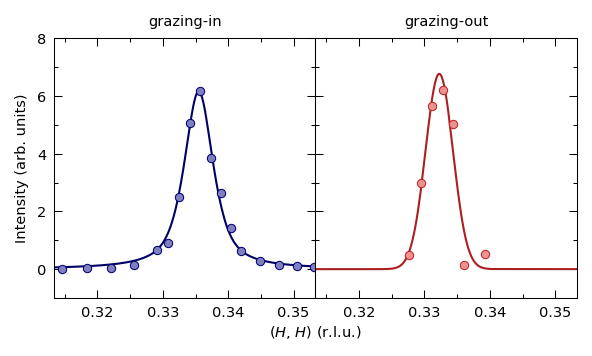

In [16]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6.75/1.5,6.75/3), dpi=150, gridspec_kw=dict(wspace=0, top=0.9, bottom=0.13))

# grazing in
x = La438_THdep1['T40']['Hrlu']
y = La438_THdep1['T40']['THdep_eline']
yerr = La438_THdep1['T40']['THdep_eline_err']
ecolor, fcolor, lcolor = get_color(mcolors.to_rgba('navy'))
axs[0].errorbar(np.abs(x), (y-La438_THdep1['T40']['bg'])*10, yerr=yerr*10, fmt='o', ls='none', ms=4, mew=0.5, elinewidth=0.5, color=fcolor, ecolor=ecolor, mec=ecolor)
# fitting
x = La438_THdep1['T40']['THdep_fit_x']
y = La438_THdep1['T40']['THdep_fit_y']
axs[0].plot(np.abs(x), (y-La438_THdep1['T40']['bg'])*10, '-', lw=1, color=lcolor)

# grazing out
x = La438_THdep2['Hrlu']
y = La438_THdep2['THdep_eline']
yerr = La438_THdep2['THdep_eline_err']
thins = np.array([15.,136.5])
thouts = thins + 27.
absorption_corrections = np.sin(np.deg2rad(thouts))/(np.sin(np.deg2rad(thins))+np.sin(np.deg2rad(thouts)))
correction = absorption_corrections[0]/absorption_corrections[1]
ecolor, fcolor, lcolor = get_color(mcolors.to_rgba('C3'))
axs[1].errorbar(np.abs(x), (y-La438_THdep2['bg'])*10*correction, yerr=yerr*10*correction, fmt='o', ls='none', ms=4, mew=0.5, elinewidth=0.5,
                color=fcolor, ecolor=ecolor, mec=ecolor)
x = La438_THdep2['THdep_fit_x']
y = La438_THdep2['THdep_fit_y']
axs[1].plot(np.abs(x), (y-La438_THdep2['bg'])*10*correction, '-', lw=1, color=lcolor)

# format
for ax in axs:
    make_theme(ax, ticklength=4)
axs[0].set_xlim(1/3-0.02,1/3+0.02)
axs[0].set_xticks(np.arange(0.32,0.36,0.01))
axs[0].set_xlabel(r'($H$, $H$) (r.l.u.)')
axs[0].xaxis.set_label_coords(1.,-0.1)
axs[0].set_title('grazing-in', fontsize=7)
axs[1].set_title('grazing-out', fontsize=7)
axs[0].set_ylim(-1,8)
axs[0].set_yticks(np.arange(0,8.1,2))
axs[0].set_ylabel('Intensity (arb. units)')

# Supplementary Figure 5

In [17]:
all_REXS = load_var(r'E:\Project_LaNiO438\paper2022\shen2022character\ED_calcs\DEd_dep_REXS_Delta_5p6.pkl')
all_occu = load_var(r'E:\Project_LaNiO438\paper2022\shen2022character\ED_calcs\DEd_dep_occupation_Delta_5p6.pkl')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


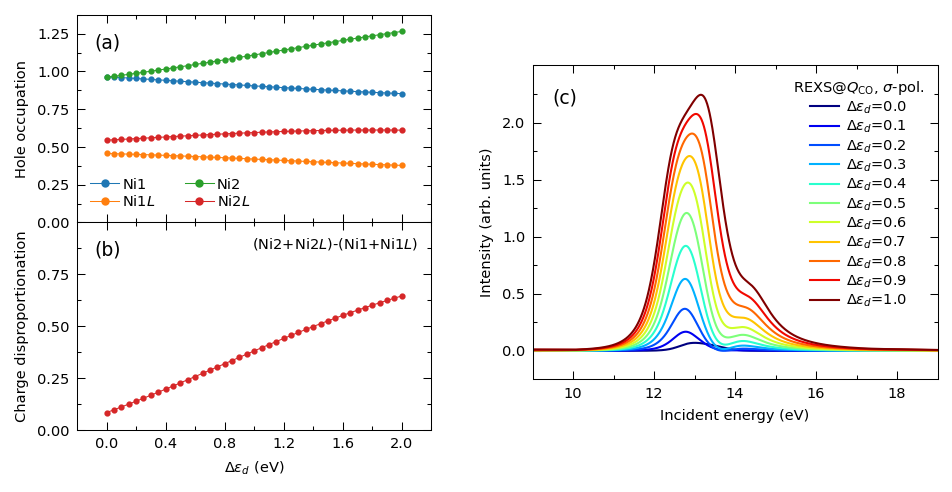

In [18]:
fig = plt.figure(figsize=(6.75,6.75/2), dpi=150)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.1, right=0.45, top=0.94, bottom=0.53)
gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.1, right=0.45, top=0.53, bottom=0.12)
gs3 = fig.add_gridspec(nrows=1, ncols=1, left=0.55, right=0.95, top=0.94-0.1, bottom=0.12+0.1)
axs = [fig.add_subplot(gs) for gs in gs1] + [fig.add_subplot(gs) for gs in gs2] + [fig.add_subplot(gs) for gs in gs3]

ax = axs[0]
ax.plot(all_occu['DEds'], [occu[0] for occu in all_occu['TM1']],  '-o', color='C0', lw=0.5, ms=2, label='Ni1')
ax.plot(all_occu['DEds'], [occu[0] for occu in all_occu['TM1L']], '-o', color='C1', lw=0.5, ms=2, label='Ni1$L$')
ax.plot(all_occu['DEds'], [occu[0] for occu in all_occu['TM2']],  '-o', color='C2', lw=0.5, ms=2, label='Ni2')
ax.plot(all_occu['DEds'], [occu[0] for occu in all_occu['TM2L']], '-o', color='C3', lw=0.5, ms=2, label='Ni2$L$')
ax.legend(ncol=2, frameon=False, markerscale=1.5, handletextpad=0.2, labelspacing=0.2, loc='lower left')
make_theme(ax, ticklength=4)
ax.tick_params(labelbottom=False)
ax.set_xlim(-0.2,2.2)
ax.set_xticks(np.arange(0,2.01,0.4))
ax.set_ylim(0, 1.25+0.25/2)
ax.set_yticks(np.arange(0,1.5,0.25))
ax.set_ylabel('Hole occupation')

ax = axs[1]
ax.plot(all_occu['DEds'], [occu1[0]+occu2[0]-occu3[0]-occu4[0] for
        occu1,occu2,occu3,occu4 in zip(all_occu['TM2'],all_occu['TM2L'],
                                       all_occu['TM1'],all_occu['TM1L'])],
              '-o', color='C3', lw=0.5, ms=2)
ax.legend(title='(Ni2+Ni2$L$)-(Ni1+Ni1$L$)', frameon=False, markerscale=1.5, handletextpad=0.5, labelspacing=0.5, loc='upper right')
make_theme(ax, ticklength=4)
ax.set_xlim(-0.2,2.2)
ax.set_xticks(np.arange(0,2.01,0.4))
ax.set_xlabel('$\\Delta\\epsilon_d$ (eV)')
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0,1,0.25))
ax.set_ylabel('Charge disproportionation')

ax = axs[2]
colors = plt.cm.jet(np.linspace(0,1,len(all_REXS['DEds'])))
for DEd, REXS, color in zip(all_REXS['DEds'], all_REXS['REXS'], colors):
    ax.plot(REXS['omega'], REXS['rexs_CO_lv'], lw=1, color=color,
            label='$\\Delta\\epsilon_d$={:.1f}'.format(DEd))
ax.legend(title='REXS@$Q_{\\mathrm{CO}}$, $\\sigma$-pol.',
          frameon=False, loc='upper right', markerscale=1.5, handletextpad=0.5, labelspacing=0.2)
make_theme(ax, ticklength=4)
ax.set_xlim(9,19)
ax.set_xticks(np.arange(10,19,2))
ax.set_xlabel('Incident energy (eV)')
ax.set_ylim(-0.25,2.5)
ax.set_yticks(np.arange(0,2.5,0.5))
ax.set_ylabel('Intensity (arb. units)')

plot_label(axs[0], '(a)', x=0.05, y=0.84, color='k')
plot_label(axs[1], '(b)', x=0.05, y=0.84, color='k')
plot_label(axs[2], '(c)', x=0.05, y=0.88, color='k')

# Supplementary Figure 6

In [19]:
Delta_dep_REXS = dict(Delta=[2.5,3.5,4.5,5.6,6.7,7.8,8.9], labels=['2p5','3p5','4p5','5p6','6p7','7p8','8p9'])
for label in Delta_dep_REXS['labels']:
    Delta_dep_REXS[label] = load_var(f'ED_calcs/REXS_Delta_{label}.pkl')

Text(0, 0.5, 'Intensity (arb. units)')

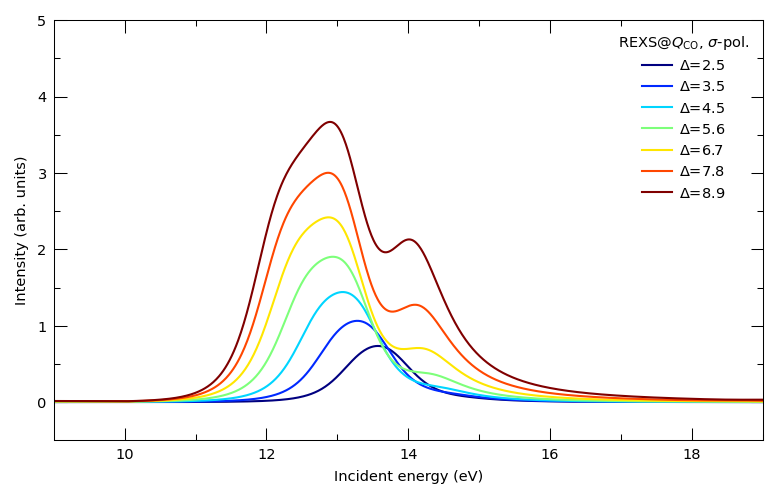

In [20]:
fig, ax = plt.subplots(figsize=(6.75,6.75/2), dpi=150, gridspec_kw=dict(left=0.2, right=0.9, top=0.95, bottom=0.12))

colors = plt.cm.jet(np.linspace(0,1,len(Delta_dep_REXS['Delta'])))
for Delta, label, color in zip(Delta_dep_REXS['Delta'], Delta_dep_REXS['labels'], colors):
    REXS = Delta_dep_REXS[label]
    # FWHM is different for different Delta
    if Delta>7:
        ax.plot(REXS['omega'], REXS['rexs_CO_lv']/5, lw=1, color=color,
                label='$\\Delta$={:.1f}'.format(Delta))
    else:
        ax.plot(REXS['omega'], REXS['rexs_CO_lv'], lw=1, color=color,
                label='$\\Delta$={:.1f}'.format(Delta))
ax.legend(title='REXS@$Q_{\\mathrm{CO}}$, $\\sigma$-pol.',
          frameon=False, loc='upper right', markerscale=1.5, handletextpad=0.5, labelspacing=0.5)
make_theme(ax, ticklength=6)
ax.set_xlim(9,19)
ax.set_xticks(np.arange(10,19,2))
ax.set_xlabel('Incident energy (eV)')
ax.set_ylim(-0.5,5)
ax.set_yticks(np.arange(0,5.1,1))
ax.set_ylabel('Intensity (arb. units)')